# Comparison of sensitivity calculation to MARS

* Using MARS DL2 / sensitivity files provided by A. Moralejo
* La Palma 4 LSTs / 15 MSTs array
* Prod3b La Palma benchmark NSB1x

## Steps performed with `pyirf`

1. Read DL2 data using uproot
2. Read applied cuts using uproot
3. Apply cuts using `pyirf.cuts.evaluate_binned_cut`
4. Calculate event weights
5. Estimate background rate
6. Calculate sensitivity

## Notes

* CTA-MARS produces the estimated shower origin in camera coordinates, so we use ctapipe
  to convert to horizontal (alt / az) coordinates

In [99]:
import os
from pathlib import Path

import numpy as np

from astropy.table import QTable
import astropy.units as u

import uproot4 as uproot

import matplotlib.pyplot as plt

In [100]:
%matplotlib notebook

In [101]:
data_path = Path(os.getenv('CTA_MARS_DATA', '../../../data/MARS/4L15M/'))


files = {
    particle.lower(): list((data_path / particle).glob('CTAflux*.root'))
    for particle in ['Gamma', 'Proton', 'Electron']
}
files['gamma'][0]

PosixPath('../../../data/MARS/4L15M/Gamma/CTAflux_64to656.root')

In [109]:
columns = {
    'event_id': ('MMcEvt./MMcEvt.fEvtNumber', dict(dtype=int)),
    'true_energy': ('MMcEvt.fEnergy', dict(unit=u.GeV)),
    'reco_energy': ('MEnergyEst.fEnergy', dict(unit=u.GeV)),
    'hadroness': ('MHadronness.fHadronness', dict()),
    'reco_source_x': ('MStereoShowerPar.fSourceX', dict(unit=u.deg)),
    'reco_source_y': ('MStereoShowerPar.fSourceY', dict(unit=u.deg)),
    'multiplicity': ('MStereoShowerPar.fNumUsedTelescopes', dict(dtype=int)),
    'multiplicity_energy': ('MStereoShowerPar.fNumEnergyTelescopes', dict(dtype=int)),
    'pointing_zen': ('MMcEvt.fTelescopeTheta', dict(unit=u.rad)),
    'pointing_az': ('MMcEvt.fTelescopePhi', dict(unit=u.rad)),
    'true_zen': ('MMcEvt.fTheta', dict(unit=u.rad)),
    'true_az': ('MMcEvt.fPhi', dict(unit=u.rad)),
    'particle_id': ('MMcEvt.fPartId', dict()),
    'mars_weight': ('weight', dict()),
}



def read_dl2_file(path):
    f = uproot.open(path)
    tree = f['Events']
    
    events = QTable()
    
    for column, (branch, kwargs) in columns.items():
        events[column] = u.Quantity(tree[branch].array(), copy=False, **kwargs)
    
    events['reco_source_fov_offset'] = np.sqrt(events['reco_source_x']**2 + events['reco_source_y']**2)
    
    for col in ['true', 'pointing']:
        events[col + '_alt'] = (np.pi / 2) * u.rad - events[col + '_zen']
    return events

In [110]:
events = read_dl2_file(files['proton'][0])
events

event_id,true_energy,reco_energy,hadroness,reco_source_x,reco_source_y,multiplicity,multiplicity_energy,pointing_zen,pointing_az,true_zen,true_az,particle_id,mars_weight,reco_source_fov_offset,true_alt,pointing_alt
,GeV,GeV,,deg,deg,,,rad,rad,rad,rad,,,deg,rad,rad
int64,float32,float32,float64,float32,float32,int64,int64,float32,float32,float32,float32,float64,float32,float32,float32,float32
1381,325.45233154296875,419.7580261230469,0.9952929019927979,1.3435084819793701,-0.48335376381874084,2,2,0.3490658700466156,6.283185005187988,0.33868977427482605,0.05294719710946083,14.0,0.8907303214073181,1.427811622619629,1.2321065664291382,1.2217304706573486
3621,6687.79736328125,2223.18896484375,0.5897563099861145,-0.39286717772483826,1.9400633573532104,2,2,0.3490658700466156,6.283185005187988,0.38481220602989197,6.259032249450684,14.0,0.10734681040048599,1.9794420003890991,1.1859841346740723,1.2217304706573486
3621,6687.79736328125,2225.46435546875,0.612277090549469,-0.5509301424026489,1.982537865638733,3,3,0.3490658700466156,6.283185005187988,0.38481220602989197,6.259032249450684,14.0,0.10734681040048599,2.057663679122925,1.1859841346740723,1.2217304706573486
3621,6687.79736328125,218.61346435546875,1.0,2.006513833999634,3.3704216480255127,2,2,0.3490658700466156,6.283185005187988,0.38481220602989197,6.259032249450684,14.0,0.10734681040048599,3.922478675842285,1.1859841346740723,1.2217304706573486
4286,361.88922119140625,110.9019775390625,0.7862161993980408,0.20377716422080994,0.04915640503168106,7,7,0.3490658700466156,6.283185005187988,0.3487250506877899,0.03381815925240517,14.0,0.8269597887992859,0.20962224900722504,1.2220712900161743,1.2217304706573486
4980,2500.543701171875,24.678945541381836,0.9360040426254272,1.638729453086853,-0.3015984296798706,2,2,0.3490658700466156,6.283185005187988,0.29562827944755554,0.18289890885353088,14.0,0.2137288898229599,1.6662520170211792,1.2751680612564087,1.2217304706573486
5517,20796.484375,866.3130493164062,1.0,0.174037367105484,4.307230472564697,6,6,0.3490658700466156,6.283185005187988,0.4292871654033661,0.004358919337391853,14.0,0.048517048358917236,4.3107452392578125,1.1415091753005981,1.2217304706573486
5535,1032.277587890625,95.76537322998047,0.987454354763031,-1.119360327720642,1.4523006677627563,2,2,0.3490658700466156,6.283185005187988,0.3944503962993622,6.192831993103027,14.0,0.3970359265804291,1.8336151838302612,1.176345944404602,1.2217304706573486


<IPython.core.display.Javascript object>


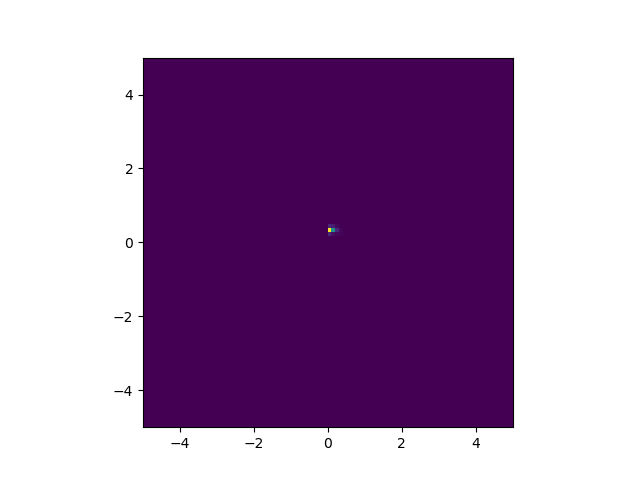

In [105]:
plt.hist2d(
    events['true_zen'].value,
    events['true_az'].value,
    bins=np.linspace(-5, 5, 101),
)
plt.gca().set_aspect(1)

In [106]:
f = uproot4.open(files['proton'][0])

In [82]:
f.keys()


['RunHeaders;1',
 'Events;1',
 'ProtonHadVsEest;1',
 'GammaHadVsEest;1',
 'ElectronHadVsEest;1',
 'ProtonTheta2VsEest;1',
 'GammaTheta2VsEest;1',
 'ElectronTheta2VsEest;1']

In [83]:
f['Events'].keys()

['MEnergyEst.',
 'MEnergyEst./MEnergyEst.MParContainer',
 'MEnergyEst./MEnergyEst.MParContainer/MEnergyEst.MParContainer.TObject',
 'MEnergyEst./MEnergyEst.MParContainer/MEnergyEst.MParContainer.TObject/MEnergyEst.MParContainer.fUniqueID',
 'MEnergyEst./MEnergyEst.MParContainer/MEnergyEst.MParContainer.TObject/MEnergyEst.MParContainer.fBits',
 'MEnergyEst./MEnergyEst.fEnergy',
 'MEnergyEst./MEnergyEst.fEnergyRMS',
 'MEnergyEst./MEnergyEst.fImpact',
 'MEnergyEst./MEnergyEst.fUncertainty',
 'MMcEvt.',
 'MMcEvt./MMcEvt.MParContainer',
 'MMcEvt./MMcEvt.MParContainer/MMcEvt.MParContainer.TObject',
 'MMcEvt./MMcEvt.MParContainer/MMcEvt.MParContainer.TObject/MMcEvt.MParContainer.fUniqueID',
 'MMcEvt./MMcEvt.MParContainer/MMcEvt.MParContainer.TObject/MMcEvt.MParContainer.fBits',
 'MMcEvt./MMcEvt.fEvtNumber',
 'MMcEvt./MMcEvt.fPartId',
 'MMcEvt./MMcEvt.fEnergy',
 'MMcEvt./MMcEvt.fThick0',
 'MMcEvt./MMcEvt.fFirstTarget',
 'MMcEvt./MMcEvt.fZFirstInteraction',
 'MMcEvt./MMcEvt.fTheta',
 'MMcEvt./M